本文中，我们将使用*Python*模块[gensim](http://radimrehurek.com/gensim/models/word2vec.html#id6)对文本训练，生成词向量（即将每个词用向量表示）。使用的数据集为Mikolov所使用的[text8](http://mattmahoney.net/dc/text8.zip)，训练模型为*skip-gram*, *CBOW*。如果你对词向量的概念不甚熟悉，可以拜读下皮果提的[CSDN博客](http://blog.csdn.net/itplus/article/details/37969519)，他深入浅出的介绍了一些列的背景知识、相关概念以及理论推导。

In [2]:
from collections import Counter
from gensim.models import word2vec 
from glove import Glove 
from glove import Corpus 
import argparse
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

首先，我们读取本地的*text8*数据，关于*gensim*里面的词向量建模工具*word2vec*，可以参看官方文档。

In [35]:
sentences = word2vec.Text8Corpus('text8')
words = open('text8').read().split()

## CBOW模型

CBOW模型主要思想是给定中心词的上下文环境来推测该中心词，按照官方文档要求，如果我们将*word2vec*函数里面的*sg*参数设置为0，则模型就是*CBOW*（Continuous Bag-Of-Words Model)。这里，我们词向量的长度设置为80，窗户宽度为5，最小频数为3（低于此的词都会被过滤），采用的是*Negative Resampling*方法。

In [36]:
model = word2vec.Word2Vec(sentences, size=80, sg=0, seed=111, window=5, min_count=3, workers=4)

我们可以查看下词向量，比如"computer"。

In [37]:
model['computer']

array([ 0.38477024,  2.63012981,  0.6402902 ,  1.07812977,  1.61791337,
        4.27556419, -1.86452901,  2.6744566 , -0.25852108,  0.4854477 ,
       -1.13226175,  1.43902063, -0.02910916, -4.01637268, -1.71094596,
       -0.05111771, -0.81647879,  1.27501702,  0.40270466,  0.55071032,
        0.22272275,  2.59782672, -0.83680689, -0.94209963, -0.9433068 ,
        1.17542553, -1.02226853,  1.9546448 , -1.36624825, -0.21889736,
        3.15863895,  3.44340801, -2.41943669,  2.40120196, -0.08883891,
       -0.66948295,  1.76611257, -1.56627381, -0.55230629, -0.56060994,
        2.25468111,  3.16728997, -0.46902773, -1.16047812,  5.99062634,
       -0.84389681,  2.30957556, -0.12609988,  0.75523067,  2.08912325,
        0.0411437 , -1.16684783,  2.3506062 , -1.21148562,  0.93167567,
        0.86798549, -1.75120819, -2.77047801, -0.85866618,  0.68660325,
       -0.48462191,  1.67592382, -0.11754839,  0.27794605, -1.43280685,
       -0.05838079,  2.63533735, -1.02506435,  1.23299849, -0.73

我们可以对这些词向量进行可视化，利用PCA降维。为方便起见，我们取词频靠前的500个单词及其词向量，然后用散点图显示。

In [38]:
#words = model.vocab.keys()

In [39]:
word_freq = Counter(words)
stopwords = ['the', 'of', 'and', 'a', 'to', 's']

In [40]:
freq_words = word_freq.most_common(500)
freq_words = [k for k,v in freq_words if k not in stopwords]

In [41]:
freq_words_vec = [model[word] for word in freq_words]

In [42]:
freq_words_vec = np.array(freq_words_vec)

In [43]:
#将词向量降维为2维向量
model_TSNE = TSNE(n_components=2, random_state=0)
freq_words_vec_2D = model_TSNE.fit_transform(freq_words_vec)

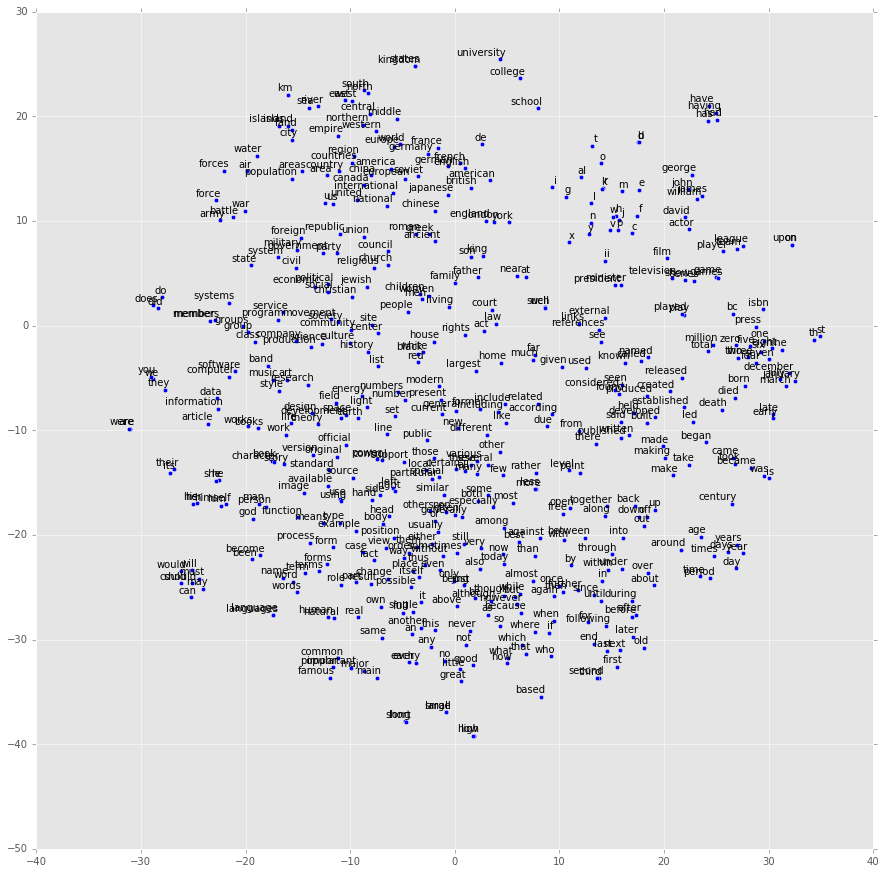

In [44]:
plt.style.use('ggplot')#设置ggplot风格的背景
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    #显示散点图并进行标注
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  plt.show()
plot(freq_words_vec_2D, freq_words)

从词向量散点图可以看出类似词语之间的聚类性，比如"school"、"university"、"college"三个单词距离很近。26个字母也分布在紧邻区域。

### Intrinsic Evaluation

下面，我们可以利用*gensim*自带的函数之间查看下不同单词之间的相似度。

In [45]:
model.similarity('boy', 'girl')

0.78450382219457038

In [46]:
y1 = model.similarity("woman", "man")
print u"woman和man的相似度为：", y1
print "--------\n"

woman和man的相似度为： 0.763963002166
--------



In [47]:
# 计算某个词的相关词列表
y2 = model.most_similar("company", topn=20)  # 20个最相关的
print u"和company最相关的词有：\n"
for item in y2:
    print item[0], item[1]
print "--------\n"

和company最相关的词有：

corporation 0.798942029476
chrysler 0.757347643375
subsidiary 0.738671720028
gm 0.698904871941
companies 0.680066108704
firm 0.679054021835
manufacturer 0.673007845879
automobile 0.672903895378
brand 0.671949982643
corp 0.670130848885
ford 0.666998147964
mazda 0.664091587067
factory 0.661278009415
toyota 0.657498598099
distributor 0.652898550034
venture 0.65157699585
plc 0.646230459213
philips 0.633281826973
mitsubishi 0.628307580948
cpr 0.626743018627
--------



In [48]:
with open('intrinsic.txt','r') as fh:
    for line in fh:
        if line=='':continue
        a, b, x = line.split()
        predicted = model.most_similar([x, b], [a])[0][0]
        print "'%s' is to '%s' as '%s' is to '%s'" % (a, b, x, predicted)
#for example in more_examples:
   # a, b, x = example.split()
    #predicted = model.most_similar([x, b], [a])[0][0]
   # print "'%s' is to '%s' as '%s' is to '%s'" % (a, b, x, predicted)
#print "--------\n"

'island' is to 'islands' as 'book' is to 'chapters'
'man' is to 'husband' as 'woman' is to 'wife'
'big' is to 'bigger' as 'small' is to 'larger'
'he' is to 'his' as 'she' is to 'her'
'large' is to 'small' as 'good' is to 'bad'
'love' is to 'loves' as 'do' is to 'chose'
'hospital' is to 'nurse' as 'school' is to 'teacher'


In [49]:
# 寻找不合群的词
y4 = model.doesnt_match("breakfast cereal dinner lunch".split())
print u"不合群的词：", y4
print "--------\n"


不合群的词： cereal
--------



In [50]:
# 保存模型，以便重用
model.save("text8.model")
# 对应的加载方式
# model_2 = word2vec.Word2Vec.load("text8.model")

## Skip-gram模型

Skip-gram实际上与CBOW模型很类似，只不过这里是给定中心词来推断上下文环境。在*gensim*里面只需修改参数便可以实现训练过程的变换。

In [52]:
model = word2vec.Word2Vec(sentences, size=80, sg=1, window=5, min_count=3, workers=4)

同样抽取前500个单词及其向量进行可视化显示。

In [53]:
freq_words_vec = [model[word] for word in freq_words]
freq_words_vec = np.array(freq_words_vec)
#将词向量降维为2维向量
model_TSNE = TSNE(n_components=2, random_state=0)
freq_words_vec_2D = model_TSNE.fit_transform(freq_words_vec)

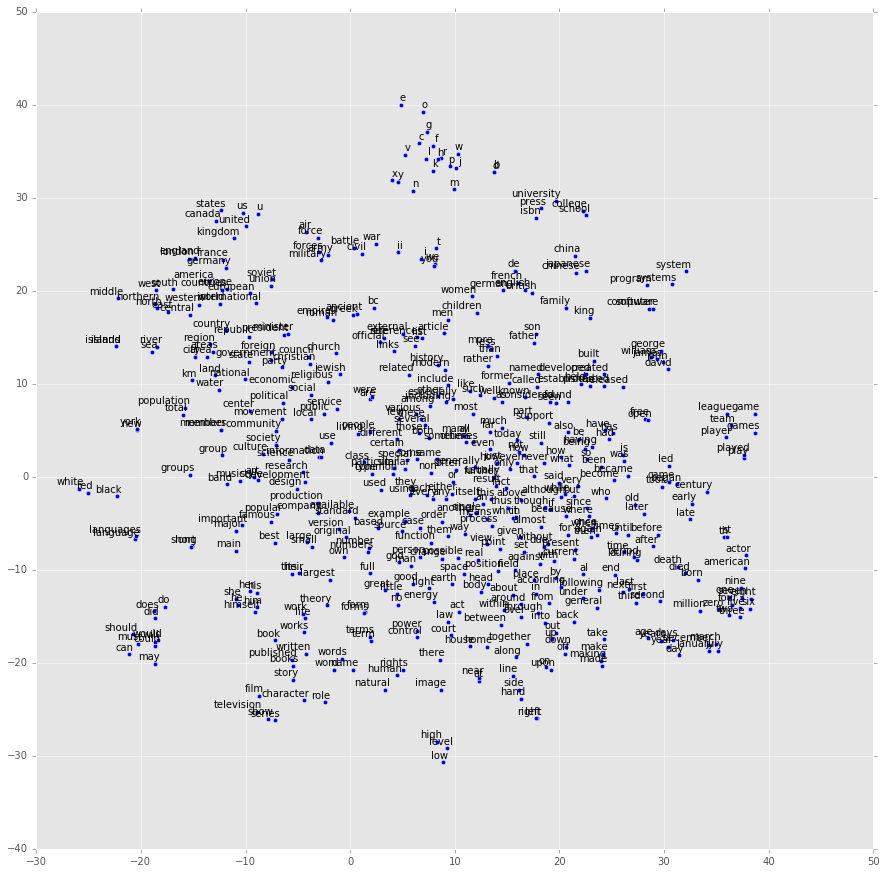

In [54]:
plot(freq_words_vec_2D, freq_words)

与CBOW模型生成的图示有所差别，但是类似的词语距离也比较近，比如"university"、"school"、"college"依然在一起，单独字母也聚集在一起。

In [58]:
model.similarity('boy', 'girl')

0.67467733343666492

In [59]:
with open('intrinsic.txt','r') as fh:
    for line in fh:
        a, b, x = line.split()
        predicted = model.most_similar([x, b], [a])[0][0]
        print "'%s' is to '%s' as '%s' is to '%s'" % (a, b, x, predicted)

'island' is to 'islands' as 'book' is to 'chapters'
'man' is to 'husband' as 'woman' is to 'wife'
'big' is to 'bigger' as 'small' is to 'larger'
'he' is to 'his' as 'she' is to 'her'
'large' is to 'small' as 'good' is to 'bad'
'love' is to 'loves' as 'do' is to 'intend'
'hospital' is to 'nurse' as 'school' is to 'teacher'


It seems skip-gram model does not perform as well as CBOW model under this setting.

## Global Vector Model

下面，我们使用另外一种词向量模型GLOVE，由斯坦福大学的Jeffrey Pennington, Richard Socher等人提出。前面的CBOW以及skip-gram模型考虑的是从给定窗口语言环境里面对词进行预测，而Glove模型则还考虑了全局的词频。具体原理可以参考[官方网站](http://www-nlp.stanford.edu/projects/glove/)。这里我使用的工具是下在于https://github.com/maciejkula/glove-python。

In [28]:
def read_corpus(filename): 
    delchars = [chr(c) for c in range(256)] 
    delchars = [x for x in delchars if not x.isalnum()] 
    delchars.remove(' ') 
    delchars = ''.join(delchars) 
    with open(filename, 'r') as datafile: 
        for line in datafile: 
            yield line.lower().translate(None, delchars).split(' ') 

这里，我们还是使用*text8*数据进行训练。

In [29]:
sentences = read_corpus('text8')

In [30]:
corpus_model = Corpus()

In [31]:
#Co-occurence矩阵窗口设置为5
corpus_model.fit(sentences, window=5)

In [118]:
corpus_model.save('corpus.model')

利用glove模型进行训练。

In [32]:
glove = Glove(no_components=80, learning_rate=0.05)

In [33]:
glove.fit(corpus_model.matrix, epochs=10, 
                  no_threads=4, verbose=True) 
glove.add_dictionary(corpus_model.dictionary)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


查看次的相似度。

In [34]:
glove.most_similar('man')

[('woman', 0.8931229862914305),
 ('young', 0.86459293263576409),
 ('child', 0.86174690011368216),
 ('person', 0.84915061761957311)]

In [134]:
help(glove.transform_paragraph)

Help on method transform_paragraph in module glove.glove:

transform_paragraph(self, paragraph, epochs=50, ignore_missing=False) method of glove.glove.Glove instance
    Transform an iterable of tokens into its vector representation
    (a paragraph vector).
    
    Experimental. This will return something close to a tf-idf
    weighted average of constituent token vectors by fitting
    rare words (with low word bias values) more closely.



In [139]:
p='i like computer science very much'
glove.transform_paragraph(p.split()).shape

(80L,)

In [132]:
with open('intrinsic.txt','r') as fh:
    for line in fh:
        a, b, x = line.split()
        print a, b, x
        predicted = glove.most_similar_paragraph([a,b,x])
        print predicted

island islands book
[('island', 0.82514361222039889), ('book', 0.80613145817848209), ('country', 0.79131409485840509), ('hosts', 0.78191297483827782), ('liaquatabad', 0.77461283510956902)]
man husband woman
[('woman', 0.92773447714193691), ('child', 0.9236786919410781), ('husband', 0.91337724006881393), ('wife', 0.91036887284950385), ('man', 0.90161756022525674)]
big bigger small
[('shorter', 0.89841751454980856), ('little', 0.83206170158548276), ('bigger', 0.82917445514974708), ('tone', 0.82550325597543384), ('larger', 0.82073038162841894)]
he his she
[('she', 0.91333737092055733), ('he', 0.84861410090198741), ('himself', 0.80838881286798969), ('met', 0.79013658762162242), ('herself', 0.78134436339402458)]
large small good
[('good', 0.92481062828869876), ('simple', 0.87774094541054304), ('similar', 0.87115460601284767), ('very', 0.86344022004457588), ('small', 0.85111575256913874)]
love loves do
[('love', 0.90294864505349393), ('got', 0.85906328791309372), ('sang', 0.84539506695741995

注意glove.dictionary里面存储的是每个单词在glove.word_vectors里面对应的坐标。

In [122]:
indice = [glove.dictionary[word] for word in freq_words]
freq_words_vec = glove.word_vectors[indice, :]
#将词向量降维为2维向量
model_TSNE = TSNE(n_components=2, random_state=0)
freq_words_vec_2D = model_TSNE.fit_transform(freq_words_vec)

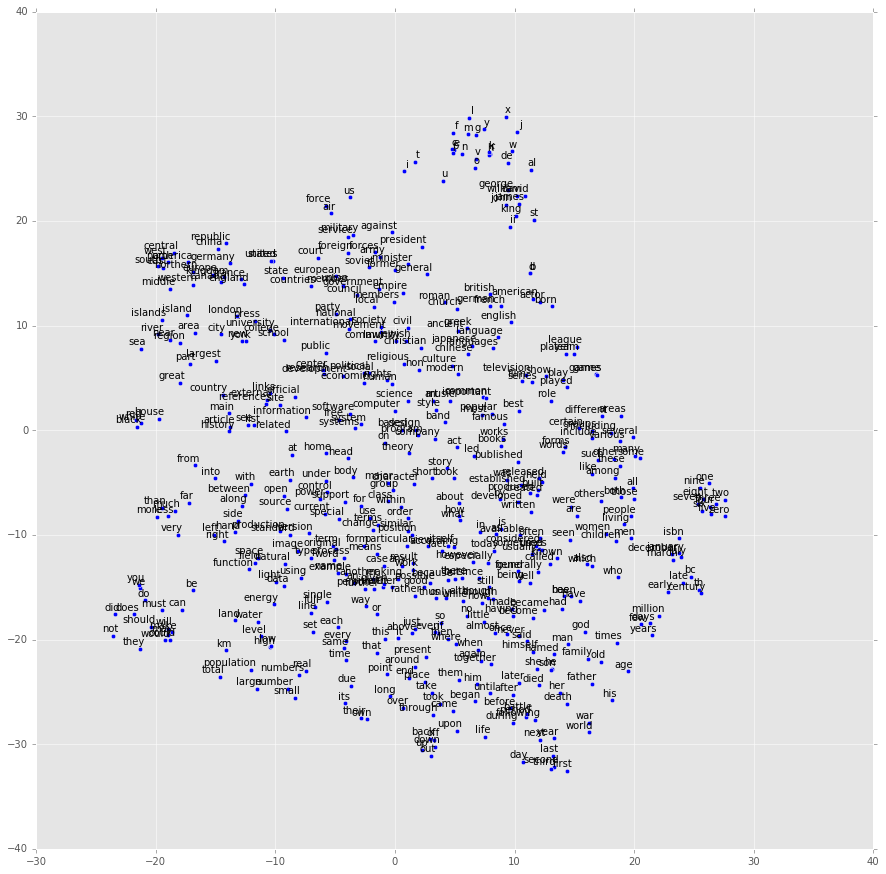

In [123]:
plot(freq_words_vec_2D, freq_words)

可以看到类似单词词向量距离比较近。

这里训练出来的词向量可以用于文本情感分析、分类、自动翻译等，但是训练好的词向量是静态的，也就是说在后续任务中不发生变化。还有一种方式，就是动态的词向量，比如在情感分类中，词向量随着每次训练的变化而变化。词向量还可以使用tensorflow等工具进行训练，相对而言，不如gensim工具简单便捷。